# FDMS TME2  
  
Florian Toque  

In this notebook we will train classifier optimizing accuracy and reducing the number of features used at the same time.  
We will compare L1 and L2 classification and confirm our classifier performance with sklearn Lasso and ElasticNet classifiers.

In [2]:
%matplotlib inline
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import copy

from sklearn.datasets import fetch_mldata
from sklearn import cross_validation
from sklearn import base
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

import matplotlib.pyplot as plt

--- 
## Data generation

In [3]:
ds = sklearn.datasets.make_classification(n_samples=2500,
                                          n_features=30,    # 30 features
                                          n_informative=8,  # only 8 informatives ones
                                          n_redundant=0,
                                          n_repeated=2,     # and 2 duplicate
                                          n_classes=2,
                                          n_clusters_per_class=1,
                                          weights=None,
                                          flip_y=0.03,
                                          class_sep=0.8,
                                          hypercube=True,
                                          shift=0.0,
                                          scale=1.0,
                                          shuffle=True,
                                          random_state=None)
X= ds[0]
y= ds[1]

# labels: [0,1] -> [-1,1]
for idx,i in enumerate(y):
    if (i==0):
        y[idx]=-1

In [4]:
print(X[0])
print(y[0])

[ 0.54991525  0.7445713  -0.74817947  0.19914777  1.89452361  1.43438157
 -2.78926078 -0.31516524 -1.51603771  0.17581455  1.31090246  1.72057743
  1.10527106 -0.3805012  -0.54601565 -1.07465358  0.92891637 -0.9810676
  0.73878389 -0.01468765 -1.66920149  0.01571569 -1.31260802  0.14947644
 -1.07465358 -0.51418413  1.95727881 -2.78926078 -0.4018432   1.14024748]
1


---
### L1

**Advantage:** good features selection

#### L1 gradient pseudocode

In [5]:
class GradientDescent(base.BaseEstimator):
    def __init__(self,theta,lamb,eps):
        self.theta=theta
        self.eps=eps
        self.lamb=lamb
        self.used_features=len(theta)

    def fit(self,X,y,nbIt=1000,printevery=-1):
        l=len(X)
        xTrans = X.transpose()
        
        for i in xrange(0,nbIt):
            #index = np.random.randint(l)
            loss = np.dot(X, self.theta) - y
            cost = np.sum(loss ** 2) * (1 / l) + (self.lamb*np.linalg.norm(self.theta))
            gradient = np.dot(xTrans,(np.dot(self.theta,xTrans)-y))
            
            if i%(nbIt/100)==0:
                thetaprime = self.theta - self.eps * (np.sign(theta)*self.lamb)
            else:
                thetaprime = self.theta - self.eps * gradient
            
            for k in xrange(0,len(theta)):
                self.theta[k] = 0 if thetaprime[k]*theta[k]<0 else thetaprime[k]
            
            
            if printevery!=-1 and i%printevery==0:
                    print("Iteration %s | Cost: %f | Score: %.03f" % (str(i).ljust(6), cost,self.score(X,y)))
                    ttt = self.nb_used_features()
                    print("%d features used"%(ttt))
                    self.used_features=ttt
            elif i%1000==0:
                ttt = self.nb_used_features()
                self.used_features=ttt
            
                
    def predict(self,x):
        ret=[]
        for i in x:
            ret.append(1 if np.dot(i,self.theta)>0 else -1)
        return ret
    
    def score(self,X,y):
        cpt=0.0
        allpred = self.predict(X)
        for idx,i in enumerate(allpred):
            cpt += 1 if i==y[idx] else 0
        return cpt/len(X)
    
    def nb_used_features(self):
        cpt=0
        for ii in self.theta:
            if ii==0:
                cpt+=1
        return len(self.theta)-cpt

In [6]:
theta = copy.deepcopy(X[0])
lamb=500
eps=0.00001

gd = GradientDescent(theta,lamb,eps)

In [7]:
nbIterations = 5000
gd.fit(X,y,nbIterations,printevery=nbIterations/10)
scores = cross_validation.cross_val_score(gd, X, y, cv=5,scoring="accuracy")
print("Cross validation scores: %s, mean: %.02f"%(scores,np.mean(scores)))

Iteration 0      | Cost: 3398.703301 | Score: 0.743
30 features used
Iteration 500    | Cost: 194.497577 | Score: 0.890
21 features used
Iteration 1000   | Cost: 194.464403 | Score: 0.890
21 features used
Iteration 1500   | Cost: 194.464383 | Score: 0.890
21 features used
Iteration 2000   | Cost: 194.464383 | Score: 0.890
21 features used
Iteration 2500   | Cost: 194.464383 | Score: 0.890
21 features used
Iteration 3000   | Cost: 194.464383 | Score: 0.890
21 features used
Iteration 3500   | Cost: 194.464383 | Score: 0.890
21 features used
Iteration 4000   | Cost: 194.464383 | Score: 0.890
21 features used
Iteration 4500   | Cost: 194.464383 | Score: 0.890
21 features used
Cross validation scores: [ 0.888  0.878  0.886  0.898  0.896], mean: 0.89


### Selecting lambda

We have only 8 informatives features over 30, and 2 repeated.  
We thrive to reach this number of features, while keeping a good classification score.

In [8]:
eps=0.00001
la = []
cross_sc = []
used_features = []

for lamb in np.arange(0,5000,200):
    theta = copy.deepcopy(X[0])
    gd = GradientDescent(theta,lamb,eps)
    nbIterations = 4000
    gd.fit(X,y,nbIterations)
    scoresSvm = cross_validation.cross_val_score(gd, X, y, cv=5,scoring="accuracy")
    print("Lamda: %s | Cross val mean: %.03f | Features: %d"%(str(lamb).ljust(5),np.mean(scoresSvm),gd.used_features))
    #print("Lamda: %.02f | Cross val mean: %.02f | Features: %d"%(lamb,gd.score(X,y),gd.used_features))
    cross_sc.append(np.mean(scoresSvm))
    la.append(lamb)
    used_features.append(gd.used_features)

Lamda: 0     | Cross val mean: 0.889 | Features: 30
Lamda: 200   | Cross val mean: 0.889 | Features: 25
Lamda: 400   | Cross val mean: 0.890 | Features: 21
Lamda: 600   | Cross val mean: 0.890 | Features: 21
Lamda: 800   | Cross val mean: 0.890 | Features: 18
Lamda: 1000  | Cross val mean: 0.888 | Features: 14
Lamda: 1200  | Cross val mean: 0.885 | Features: 13
Lamda: 1400  | Cross val mean: 0.886 | Features: 10
Lamda: 1600  | Cross val mean: 0.883 | Features: 10
Lamda: 1800  | Cross val mean: 0.879 | Features: 9
Lamda: 2000  | Cross val mean: 0.878 | Features: 9
Lamda: 2200  | Cross val mean: 0.878 | Features: 9
Lamda: 2400  | Cross val mean: 0.878 | Features: 9
Lamda: 2600  | Cross val mean: 0.877 | Features: 9
Lamda: 2800  | Cross val mean: 0.876 | Features: 9
Lamda: 3000  | Cross val mean: 0.874 | Features: 9
Lamda: 3200  | Cross val mean: 0.872 | Features: 9
Lamda: 3400  | Cross val mean: 0.872 | Features: 9
Lamda: 3600  | Cross val mean: 0.874 | Features: 9
Lamda: 3800  | Cross v

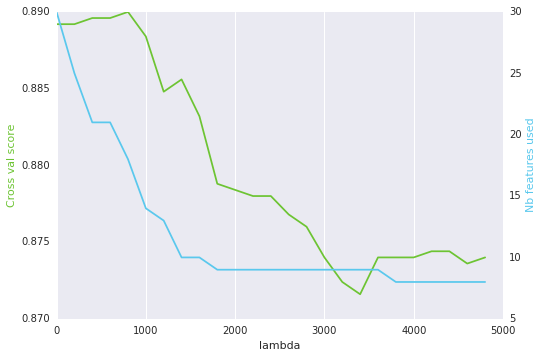

In [9]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(la, cross_sc, '#6DC433')
ax2.plot(la, used_features, '#5AC8ED')

ax1.set_xlabel('lambda')
ax1.set_ylabel('Cross val score', color='#6DC433')
ax2.set_ylabel('Nb features used', color='#5AC8ED')

ax1.yaxis.grid(False)
ax2.grid(False)
plt.show()

We can see that only 8 features are usefull (score 87%), with more features we can make overfitting and scores are only 2% better.

---
### L2

The difference between the L1 and L2 regularization is that L1 work on the sum of the weights, and L2 work on the sum of the square of the weights, and is therefor more sensitive to outliers.

**Advantage:** good predictions with significants constraints

In [11]:
class GradientDescentL2(base.BaseEstimator):
    def __init__(self,theta,lamb,eps):
        self.theta=theta
        self.eps=eps
        self.lamb=lamb
        self.used_features=len(theta)

    def fit(self,X,y,nbIt=1000,printevery=-1):
        l=len(X)
        xTrans = X.transpose()
        
        for i in xrange(0,nbIt):
            index = np.random.randint(l)
            loss = np.dot(X, self.theta) - y
            cost = np.sum(loss ** 2) * (1 / l) + (self.lamb*np.linalg.norm(self.theta))**2
            gradient = np.dot(xTrans,(np.dot(self.theta,xTrans)-y))
            
            if i%(nbIt/100)==0:
                thetaprime = self.theta - self.eps * (np.sign(theta)*self.lamb)
            else:
                thetaprime = self.theta - self.eps * gradient
            
            for k in xrange(0,len(theta)):
                self.theta[k] = 0 if thetaprime[k]*theta[k]<0 else thetaprime[k]
            
            
            if printevery!=-1 and i%printevery==0:
                    print("Iteration %s | Cost: %f | Score: %.03f" % (str(i).ljust(6), cost,self.score(X,y)))
                    ttt = self.nb_used_features()
                    print("%d features used"%(ttt))
                    self.used_features=ttt
            elif i%1000==0:
                ttt = self.nb_used_features()
                self.used_features=ttt
            
                
    def predict(self,x):
        ret=[]
        for i in x:
            ret.append(1 if np.dot(i,self.theta)>0 else -1)
        return ret
    
    def score(self,X,y):
        cpt=0.0
        allpred = self.predict(X)
        for idx,i in enumerate(allpred):
            cpt += 1 if i==y[idx] else 0
        return cpt/len(X)
    
    def nb_used_features(self):
        cpt=0
        for ii in self.theta:
            if ii==0:
                cpt+=1
        return len(self.theta)-cpt

#### Test with only 200 samples

In [12]:
ds = sklearn.datasets.make_classification(n_samples=200,
                                          n_features=30,    # 30 features
                                          n_informative=8,  # only 8 informatives ones
                                          n_redundant=0,
                                          n_repeated=2,     # and 2 duplicate
                                          n_classes=2,
                                          n_clusters_per_class=1,
                                          weights=None,
                                          flip_y=0.01,
                                          class_sep=0.8,
                                          hypercube=True,
                                          shift=0.0,
                                          scale=1.0,
                                          shuffle=True,
                                          random_state=None)
X= ds[0]
y= ds[1]

# labels: [0,1] -> [-1,1]
for idx,i in enumerate(y):
    if (i==0):
        y[idx]=-1

In [13]:
theta = copy.deepcopy(X[0])
lamb=1000
eps=0.00001

gd = GradientDescentL2(theta,lamb,eps)
#gd.tmp

In [14]:
nbIterations = 5000
gd.fit(X,y,nbIterations,printevery=nbIterations/10)
scores = cross_validation.cross_val_score(gd, X, y, cv=5,scoring="accuracy")
print("Cross validation scores: %s, mean: %.02f"%(scores,np.mean(scores)))

Iteration 0      | Cost: 82880412.729433 | Score: 0.515
30 features used
Iteration 500    | Cost: 2351720.934932 | Score: 0.730
26 features used
Iteration 1000   | Cost: 275501.528014 | Score: 0.925
18 features used
Iteration 1500   | Cost: 126137.014258 | Score: 0.955
11 features used
Iteration 2000   | Cost: 117457.520732 | Score: 0.955
7 features used
Iteration 2500   | Cost: 114989.959085 | Score: 0.960
7 features used
Iteration 3000   | Cost: 114515.659670 | Score: 0.960
7 features used
Iteration 3500   | Cost: 114605.770301 | Score: 0.960
7 features used
Iteration 4000   | Cost: 114796.496900 | Score: 0.960
7 features used
Iteration 4500   | Cost: 114961.203500 | Score: 0.960
7 features used
Cross validation scores: [ 0.875  0.9    0.95   0.95   0.975], mean: 0.93


We can see that L2 is more sensitive to outliers because it chooses 7 usefull features against 8 for L1

### Selecting lambda

Similar to L1

In [18]:
eps=0.00001
la = []
cross_sc = []
used_features = []

for lamb in np.arange(0,4000,200):
    theta = copy.deepcopy(X[0])
    gd = GradientDescentL2(theta,lamb,eps)
    nbIterations = 5000
    gd.fit(X,y,nbIterations)
    scoresSvm = cross_validation.cross_val_score(gd, X, y, cv=5,scoring="accuracy")
    print("Lamda: %s | Cross val mean: %.03f | Features: %d"%(str(lamb).ljust(5),np.mean(scoresSvm),gd.used_features))
    cross_sc.append(np.mean(scoresSvm))
    la.append(lamb)
    used_features.append(gd.used_features)

Lamda: 0     | Cross val mean: 0.935 | Features: 30
Lamda: 200   | Cross val mean: 0.955 | Features: 14
Lamda: 400   | Cross val mean: 0.950 | Features: 11
Lamda: 600   | Cross val mean: 0.955 | Features: 10
Lamda: 800   | Cross val mean: 0.935 | Features: 7
Lamda: 1000  | Cross val mean: 0.930 | Features: 7
Lamda: 1200  | Cross val mean: 0.910 | Features: 7
Lamda: 1400  | Cross val mean: 0.895 | Features: 7
Lamda: 1600  | Cross val mean: 0.890 | Features: 7
Lamda: 1800  | Cross val mean: 0.890 | Features: 6
Lamda: 2000  | Cross val mean: 0.890 | Features: 6
Lamda: 2200  | Cross val mean: 0.890 | Features: 6
Lamda: 2400  | Cross val mean: 0.890 | Features: 6
Lamda: 2600  | Cross val mean: 0.890 | Features: 6
Lamda: 2800  | Cross val mean: 0.890 | Features: 6
Lamda: 3000  | Cross val mean: 0.890 | Features: 6
Lamda: 3200  | Cross val mean: 0.890 | Features: 6
Lamda: 3400  | Cross val mean: 0.890 | Features: 6
Lamda: 3600  | Cross val mean: 0.890 | Features: 6
Lamda: 3800  | Cross val me

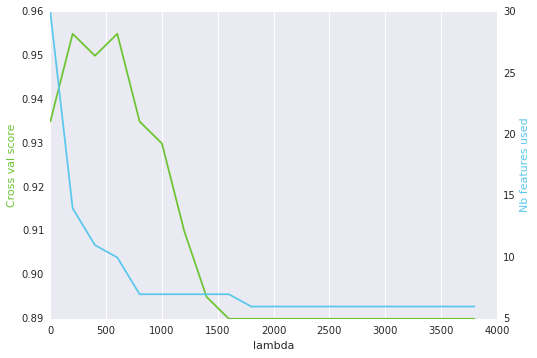

In [20]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(la, cross_sc, '#6DC433')
ax2.plot(la, used_features, '#5AC8ED')

ax1.set_xlabel('lambda')
ax1.set_ylabel('Cross val score', color='#6DC433')
ax2.set_ylabel('Nb features used', color='#5AC8ED')

ax1.yaxis.grid(False)
ax2.grid(False)
plt.show()

L2 chooses less features than L1, and keeps a good score. 

---
## Evaluation using sklearn Lasso

Sklearn's Lasso works the same, although way faster, and a lambda 0 < λ < 1 is more practical

In [48]:
#used to cross-val on lasso and elastic-net
def scorer(estimator, X, y):
    pred = estimator.predict(X)
    cpt=0.0
    for idx,i in enumerate(pred):
        if i<0:
            cpt += 1 if y[idx]==-1 else 0
        else:
            cpt += 1 if y[idx]==1 else 0
    return cpt/len(y)

In [49]:
lass = Lasso(alpha = 0.2)
lass.fit(X,y)

scores = cross_validation.cross_val_score(lass, X, y, cv=5,scoring=scorer)
print("Cross validation scores: %s, mean: %.02f"%(scores,np.mean(scores)))
print(lass.coef_)
print("Feature used: %d"%np.count_nonzero(lass.coef_))

Cross validation scores: [ 0.9    0.875  0.85   0.825  0.9  ], mean: 0.87
[ -6.08294253e-02   1.86963827e-03  -0.00000000e+00   0.00000000e+00
  -0.00000000e+00   0.00000000e+00   0.00000000e+00  -0.00000000e+00
   0.00000000e+00  -0.00000000e+00   0.00000000e+00  -0.00000000e+00
  -0.00000000e+00   1.96742698e-01  -0.00000000e+00  -0.00000000e+00
  -0.00000000e+00   1.29244064e-01   0.00000000e+00  -0.00000000e+00
   4.52281825e-16  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
  -0.00000000e+00  -2.05700035e-01  -0.00000000e+00  -0.00000000e+00
  -0.00000000e+00  -0.00000000e+00]
Feature used: 6


In [50]:
eps=0.00001
la = []
cross_sc = []
used_features = []

for lamb in np.arange(0.05,1.05,0.05):
    theta = copy.deepcopy(X[0])
    gd = Lasso(alpha = lamb)
    nbIterations = 4000
    gd.fit(X,y)
    scoresSvm = cross_validation.cross_val_score(gd, X, y, cv=5,scoring=scorer)
    print("Lamda: %s | Cross val mean: %.03f | Features: %d"%(str(lamb).ljust(5),np.mean(scoresSvm),np.count_nonzero(gd.coef_)))
    #print("Lamda: %.02f | Cross val mean: %.02f | Features: %d"%(lamb,gd.score(X,y),gd.used_features))
    cross_sc.append(np.mean(scoresSvm))
    la.append(lamb)
    used_features.append(np.count_nonzero(gd.coef_))

Lamda: 0.05  | Cross val mean: 0.900 | Features: 11
Lamda: 0.1   | Cross val mean: 0.895 | Features: 7
Lamda: 0.15  | Cross val mean: 0.880 | Features: 6
Lamda: 0.2   | Cross val mean: 0.870 | Features: 6
Lamda: 0.25  | Cross val mean: 0.845 | Features: 6
Lamda: 0.3   | Cross val mean: 0.840 | Features: 5
Lamda: 0.35  | Cross val mean: 0.840 | Features: 5
Lamda: 0.4   | Cross val mean: 0.840 | Features: 4
Lamda: 0.45  | Cross val mean: 0.835 | Features: 4
Lamda: 0.5   | Cross val mean: 0.830 | Features: 4
Lamda: 0.55  | Cross val mean: 0.810 | Features: 4
Lamda: 0.6   | Cross val mean: 0.780 | Features: 4
Lamda: 0.65  | Cross val mean: 0.760 | Features: 4
Lamda: 0.7   | Cross val mean: 0.740 | Features: 4
Lamda: 0.75  | Cross val mean: 0.695 | Features: 2
Lamda: 0.8   | Cross val mean: 0.665 | Features: 2
Lamda: 0.85  | Cross val mean: 0.650 | Features: 1
Lamda: 0.9   | Cross val mean: 0.605 | Features: 1
Lamda: 0.95  | Cross val mean: 0.590 | Features: 1
Lamda: 1.0   | Cross val mean:

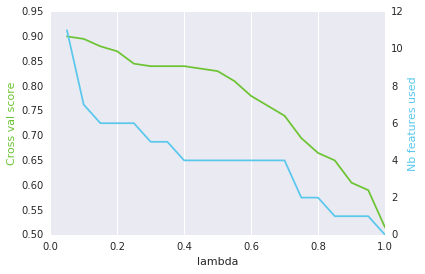

In [51]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(la, cross_sc, '#6DC433')
ax2.plot(la, used_features, '#5AC8ED')

ax1.set_xlabel('lambda')
ax1.set_ylabel('Cross val score', color='#6DC433')
ax2.set_ylabel('Nb features used', color='#5AC8ED')

ax1.yaxis.grid(False)
ax2.grid(False)
plt.show()

---

---
## Comparaison of L1 and L2 using sklearn ElasticNet

In [52]:
lass = ElasticNet(alpha = 0.2, l1_ratio=0)
lass.fit(X,y)
scores = cross_validation.cross_val_score(lass, X, y, cv=5,scoring=scorer)
print("Cross validation scores: %s, mean: %.02f"%(scores,np.mean(scores)))
print("Feature used: %d"%np.count_nonzero(lass.coef_))

lass = ElasticNet(alpha = 0.2, l1_ratio=0.5)
lass.fit(X,y)
scores = cross_validation.cross_val_score(lass, X, y, cv=5,scoring=scorer)
print("Cross validation scores: %s, mean: %.02f"%(scores,np.mean(scores)))
print("Feature used: %d"%np.count_nonzero(lass.coef_))

lass = ElasticNet(alpha = 0.2, l1_ratio=1)
lass.fit(X,y)
scores = cross_validation.cross_val_score(lass, X, y, cv=5,scoring=scorer)
print("Cross validation scores: %s, mean: %.02f"%(scores,np.mean(scores)))
print("Feature used: %d"%np.count_nonzero(lass.coef_))

Cross validation scores: [ 0.9    0.9    0.9    0.9    0.925], mean: 0.91
Feature used: 30
Cross validation scores: [ 0.9    0.9    0.875  0.85   0.925], mean: 0.89
Feature used: 8
Cross validation scores: [ 0.9    0.875  0.85   0.825  0.9  ], mean: 0.87
Feature used: 6


We observe that, as expected, the more we take L1 into account the less features are used.

In [53]:
eps=0.00001
la = []
cross_sc = []
used_features = []

for lamb in np.arange(0.05,1.05,0.05):
    theta = copy.deepcopy(X[0])
    gd = ElasticNet(alpha = 0.2, l1_ratio=lamb)
    nbIterations = 4000
    gd.fit(X,y)
    scoresSvm = cross_validation.cross_val_score(gd, X, y, cv=5,scoring=scorer)
    print("Lamda: %s | Cross val mean: %.03f | Features: %d"%(str(lamb).ljust(5),np.mean(scoresSvm),np.count_nonzero(gd.coef_)))
    #print("Lamda: %.02f | Cross val mean: %.02f | Features: %d"%(lamb,gd.score(X,y),gd.used_features))
    cross_sc.append(np.mean(scoresSvm))
    la.append(lamb)
    used_features.append(np.count_nonzero(gd.coef_))

Lamda: 0.05  | Cross val mean: 0.900 | Features: 26
Lamda: 0.1   | Cross val mean: 0.905 | Features: 22
Lamda: 0.15  | Cross val mean: 0.900 | Features: 19
Lamda: 0.2   | Cross val mean: 0.895 | Features: 14
Lamda: 0.25  | Cross val mean: 0.895 | Features: 12
Lamda: 0.3   | Cross val mean: 0.900 | Features: 11
Lamda: 0.35  | Cross val mean: 0.895 | Features: 11
Lamda: 0.4   | Cross val mean: 0.900 | Features: 11
Lamda: 0.45  | Cross val mean: 0.895 | Features: 8
Lamda: 0.5   | Cross val mean: 0.890 | Features: 8
Lamda: 0.55  | Cross val mean: 0.885 | Features: 7
Lamda: 0.6   | Cross val mean: 0.885 | Features: 7
Lamda: 0.65  | Cross val mean: 0.880 | Features: 7
Lamda: 0.7   | Cross val mean: 0.880 | Features: 7
Lamda: 0.75  | Cross val mean: 0.875 | Features: 7
Lamda: 0.8   | Cross val mean: 0.875 | Features: 7
Lamda: 0.85  | Cross val mean: 0.875 | Features: 6
Lamda: 0.9   | Cross val mean: 0.875 | Features: 6
Lamda: 0.95  | Cross val mean: 0.875 | Features: 6
Lamda: 1.0   | Cross va

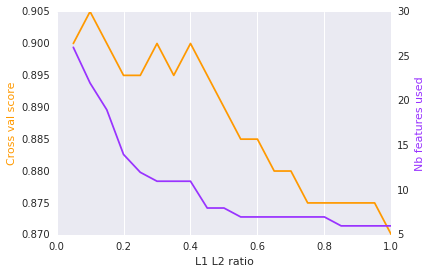

In [54]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(la, cross_sc, '#FF9900')
ax2.plot(la, used_features, '#9933FF')

ax1.set_xlabel('L1 L2 ratio')
ax1.set_ylabel('Cross val score', color='#FF9900')
ax2.set_ylabel('Nb features used', color='#9933FF')

ax1.yaxis.grid(False)
ax2.grid(False)
plt.show()

# In conclusion,
both L1 and L2 classifiers make good classification whitout keeping all features. In general we prefer to keep the minimum of features to avoid overfitting. Selection features is a good thing to do in data classification (or kaggle) to focus on the usefull features.


---